In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine, load_linnerud

from scipy.linalg import sqrtm

In [141]:
#Loading data in a DataFrame:
data_wine = load_wine(as_frame=True)
data_physio = load_linnerud(as_frame=True)

#Loading wine features in a matrix:
X_wine = np.array(data_wine.data)

#Loading exercise/physio. data
X_ex = data_physio.data  # Exercise variables
X_physio = data_physio.target # Physiological variables
X_ph,Y_ph = np.array(X_ex),np.array(X_physio)

<Axes: >

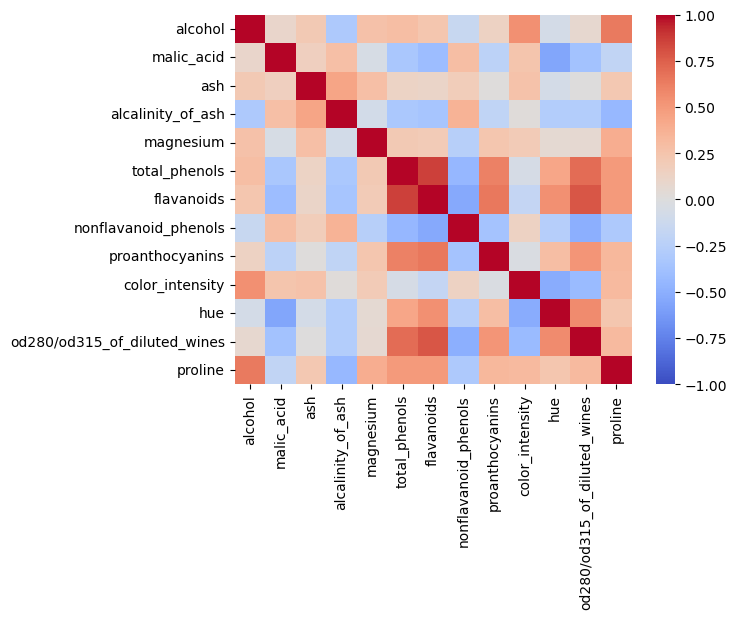

In [143]:

# Calculate the correlation matrix
corr_matrix_wine = data_wine.data.corr()


# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix_wine, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)


<Axes: >

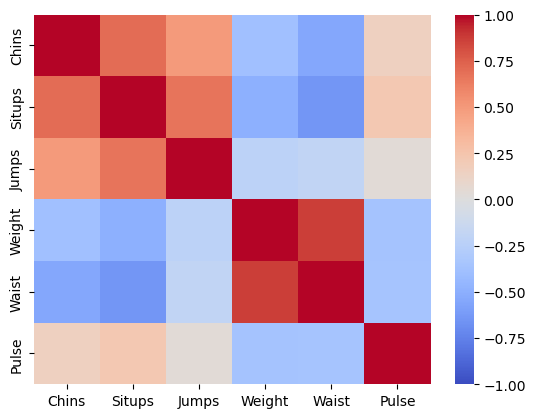

In [145]:
df_physio = pd.concat([X_ex,X_physio],axis=1)

# Calculate the correlation matrix
corr_matrix_physio = df_physio.corr()


# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix_physio, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)


TASTE variable Group : ['alcohol' 'od280/od315_of_diluted_wines' 'proline']
ASPECT variabl Group : ['color_intensity' 'hue']


<Axes: >

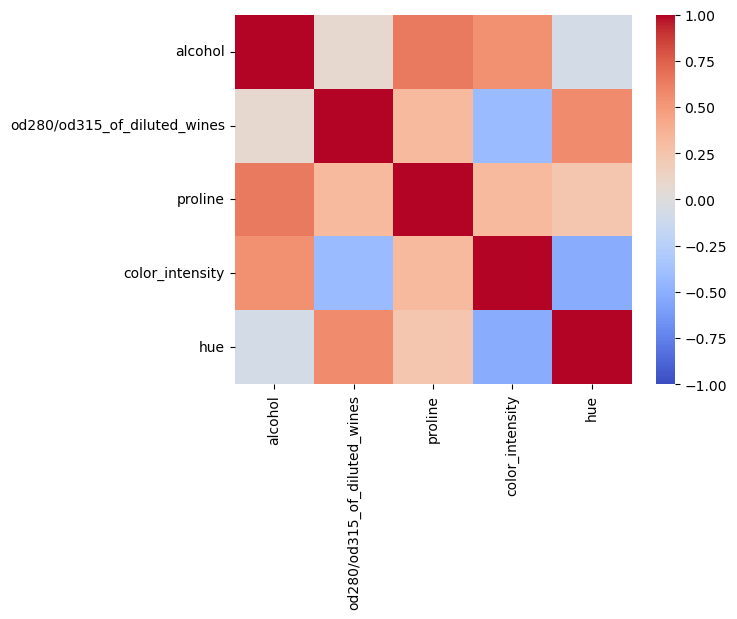

In [147]:
ind_X = [0,11,12]
ind_Y = [9,10]

print('TASTE variable Group :',np.array(data_wine.feature_names)[ind_X])
print('ASPECT variabl Group :',np.array(data_wine.feature_names)[ind_Y])
X_w = data_wine.data.iloc[:,ind_X] 
Y_w = data_wine.data.iloc[:,ind_Y] 

df_wine = pd.concat([X_w,Y_w],axis=1)

# Calculate the correlation matrix
corr_matrix_wine = df_wine.corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix_wine, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)

In [149]:
def empirical_cov_mat(X,Y):
    nx = X.shape[0]
    ny = Y.shape[0] 
        
    X_c = X - np.mean(X, axis=0)
    Y_c = Y - np.mean(Y, axis=0)
    if nx != ny:
        print('ERROR : X,Y have not the same sample size')
    else:
        S_XX = (X_c.T.dot(X_c))/nx
        S_YY = (Y_c.T.dot(Y_c))/nx
        S_XY = (X_c.T.dot(Y_c))/nx
        S_YX = S_XY.T
    return S_XX,S_YY,S_XY,S_YX

In [172]:
def canonical_correlation_analysis(X, Y):
    """
    Perform Canonical Correlation Analysis (CCA) on two multivariate datasets X and Y.

    Returns:
    C_X : numpy.ndarray
        Canonical variables for X.
    C_Y : numpy.ndarray
        Canonical variables for Y.
    ccs : numpy.ndarray
        Canonical correlations.
    """

    
    # Step 1: Compute covariance matrices
    S_xx,S_yy,S_xy,S_yx = empirical_cov_mat(X,Y)
    
    # Step 2: Compute the inverse and sqrt of the covariance matrices
    if S_xx.size==1:
        S_xx_inv=1/S_xx
    else:
        S_xx_inv = np.linalg.inv(S_xx)
    if S_yy.size==1:    
        S_yy_inv=1/S_yy
    else:
        S_yy_inv = np.linalg.inv(S_yy)

    if S_xx_inv.size==1:
        SQx= np.sqrt(S_xx_inv)
    else:
        SQx =sqrtm(S_xx_inv)
    if S_yy_inv.size ==1 :
        SQy=np.sqrt(S_yy_inv)
    else:
        SQy =sqrtm(S_yy_inv)
        
    M = SQx.dot(S_xy).dot(SQy)

    U,ccs,Vt = np.linalg.svd(M)

    a = SQx.dot(U)
    b = SQy.dot(Vt.T)

    C_X = (X - np.mean(X, axis=0)).dot(a)

    C_Y = (Y - np.mean(Y, axis=0)).dot(b)


    return C_X, C_Y, a, b, ccs

In [174]:
X_c_w, Y_c_w, a_w, b_w, sing_value_w = canonical_correlation_analysis(np.array(X_w), np.array(Y_w))
X_c_ph, Y_c_ph, a_ph, b_ph, sing_value_ph = canonical_correlation_analysis(np.array(X_ph), np.array(Y_ph))


Matrix Correlation of Canonical Variables (Wine):


<Axes: >

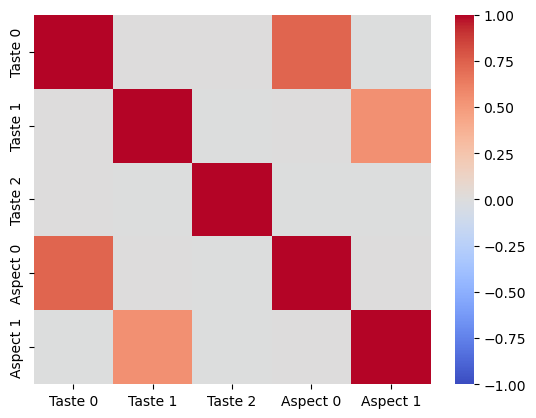

In [176]:
# Plot canonical correlations
print("\nMatrix Correlation of Canonical Variables (Wine):")

df_T = pd.DataFrame()

for k in range(len(ind_X)):
    df_T['Taste '+str(k)] = X_c_w[:,k]
for k in range(len(ind_Y)):
    df_T['Aspect '+str(k)] = Y_c_w[:,k]

new_cross_corr = df_T.corr()
sns.heatmap(new_cross_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)




Matrix Correlation of Canonical Variables (Physio.):


<Axes: >

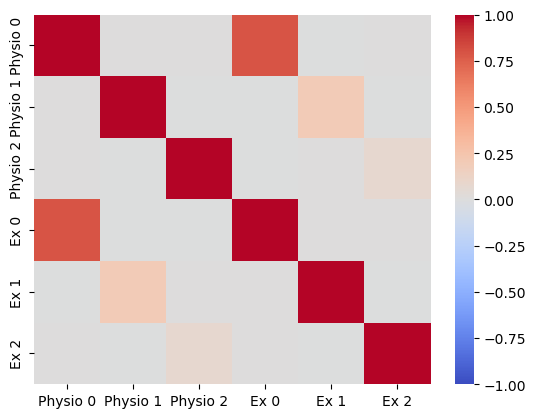

In [178]:
print("\nMatrix Correlation of Canonical Variables (Physio.):")
df_T = pd.DataFrame()
col_X = []
col_Y = []
for k in range(3):
    col_X.append('Physio '+str(k))
    col_Y.append('Ex '+str(k))
    df_T['Physio '+str(k)] = X_c_ph[:,k]
    df_T['Ex '+str(k)] = Y_c_ph[:,k]

# .loc[col_X+ col_Y,col_X+ col_Y] to sort variables in the right order
new_cross_corr = df_T.corr().loc[col_X+ col_Y,col_X+ col_Y]
sns.heatmap(new_cross_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)


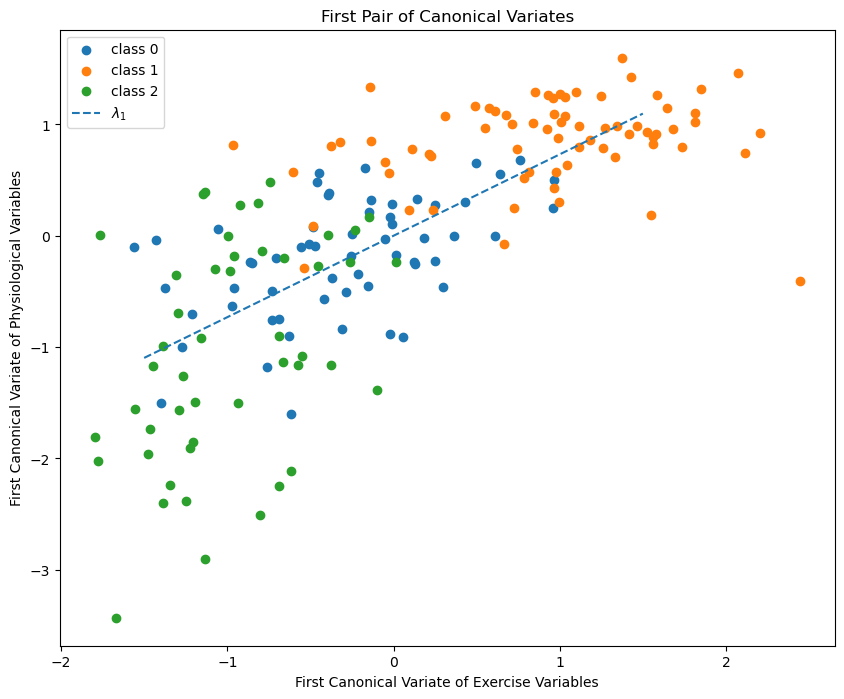

In [180]:
target = data_wine.target


# Plot the first pair of canonical variates
plt.figure(figsize=(10, 8))
for i in range(3):
    plt.scatter(X_c_w[target==i, 0], Y_c_w[target==i, 0], label='class '+str(i))
plt.plot(np.linspace(-1.5, 1.5,100), sing_value_w[0]*np.linspace(-1.5, 1.5,100),'--',label=r'$\lambda_1$')


plt.xlabel('First Canonical Variate of Exercise Variables')
plt.ylabel('First Canonical Variate of Physiological Variables')
plt.title('First Pair of Canonical Variates')
plt.legend()
plt.show()

# Plot the first pair of canonical variates
plt.figure(figsize=(10, 8))
plt.scatter(X_c_ph[:, 0], Y_c_ph[:, 0])
plt.plot(np.linspace(-1.5, 1.5,100), sing_value_ph[0]*np.linspace(-1.5, 1.5,100),'--',label=r'$\lambda_1$')



plt.xlabel('First Canonical Variate of Exercise Variables')
plt.ylabel('First Canonical Variate of Physiological Variables')
plt.title('First Pair of Canonical Variates')
plt.legend()
plt.show()

In [182]:
def mean_sq_error(y,y_pred):
    return np.mean(np.power(y-y_pred,2))

y_pred_wine = sing_value_w[0]*X_c_w[:,0]
y_pred_ph = sing_value_ph[0]*X_c_ph[:,0]

print('Mean squared error lin. regressor (Wine) : ',mean_sq_error(Y_c_w[:,0],y_pred_wine))
print('Mean squared error lin. regressor (Physio.) : ',mean_sq_error(Y_c_ph[:,0],y_pred_ph))

Mean squared error lin. regressor (Wine) :  0.46511812154890003
Mean squared error lin. regressor (Physio.) :  0.3670076646204166


In [184]:
def plot_correlation_circles( X, Y,X_c,Y_c, X_names= None, Y_names = None, X_can = None, Y_can= None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    # Correlations for X and Y original variables with X canonical variables
    ### ...TO FILL...

    y_loadings_x = np.corrcoef(Y.T, X_c.T)[:Y.shape[1], Y.shape[1]:]
    x_loadings_x = np.corrcoef(X.T, X_c.T)[:X.shape[1], X.shape[1]:]

    ###
    # Correlations for X and Y original variables with Y canonical variables
    ### ...TO FILL...

    y_loadings_y = np.corrcoef(Y.T, Y_c.T)[:Y.shape[1], Y.shape[1]:] 
    x_loadings_y = np.corrcoef(X.T, Y_c.T)[:X.shape[1], X.shape[1]:]

    ###

    
    # Plot relative to X canonical variables
    ax1.set_title('Correlation Circle (X Canonical Variables)')
    for i in range(X.shape[1]):
        ax1.arrow(0, 0, x_loadings_x[i, 0], x_loadings_x[i, 1], head_width=0.05, head_length=0.05, fc='blue', ec='blue',length_includes_head=True)
        if X_names is None:
            ax1.text(x_loadings_x[i, 0]*1.15, x_loadings_x[i, 1]*1.15, f'X{i+1}', color='blue')
        else:
            ax1.text(x_loadings_x[i, 0]*1.15, x_loadings_x[i, 1]*1.15, X_names[i], color='blue')    
    for i in range(Y.shape[1]):
        ax1.arrow(0, 0, y_loadings_x[i, 0], y_loadings_x[i, 1], head_width=0.05, head_length=0.05, fc='red', ec='red',length_includes_head=True)
        if Y_names is None:
            ax1.text(y_loadings_x[i, 0]*1.15, y_loadings_x[i, 1]*1.15, f'Y{i+1}', color='red')
        else:
            ax1.text(y_loadings_x[i, 0]*1.15, y_loadings_x[i, 1]*1.15, Y_names[i], color='red')
            
    ax1.add_artist(plt.Circle((0,0), 1, color='gray', fill=False))
    ax1.axhline(y=0, color='k', linestyle='--')
    ax1.axvline(x=0, color='k', linestyle='--')
    ax1.set_xlim(-1.2, 1.2)
    ax1.set_ylim(-1.2, 1.2)
    ax1.set_aspect('equal')
    if X_can is not None:
        ax1.set_xlabel('X ('+X_can+') CC1')
        ax1.set_ylabel('X ('+X_can+') CC2')
    else:
        ax1.set_xlabel('X CC1')
        ax1.set_ylabel('X CC2')    
    # Plot relative to Y canonical variables
    ax2.set_title('Correlation Circle (Y Canonical Variables)')
    for i in range(X.shape[1]):
        ax2.arrow(0, 0, x_loadings_y[i, 0], x_loadings_y[i, 1], head_width=0.05, head_length=0.05, fc='blue', ec='blue',length_includes_head=True)
        if X_names is None:
            ax2.text(x_loadings_y[i, 0]*1.15, x_loadings_y[i, 1]*1.15, f'X{i+1}', color='blue')
        else:
            ax2.text(x_loadings_y[i, 0]*1.15, x_loadings_y[i, 1]*1.15, X_names[i], color='blue')            
    for i in range(Y.shape[1]):
        ax2.arrow(0, 0, y_loadings_y[i, 0], y_loadings_y[i, 1], head_width=0.05, head_length=0.05, fc='red', ec='red',length_includes_head=True)
        if X_names is None:
            ax2.text(y_loadings_y[i, 0]*1.15, y_loadings_y[i, 1]*1.15, f'Y{i+1}', color='red')
        else:
            ax2.text(y_loadings_y[i, 0]*1.15, y_loadings_y[i, 1]*1.15, Y_names[i], color='red')
            
    ax2.add_artist(plt.Circle((0,0), 1, color='gray', fill=False))
    ax2.axhline(y=0, color='k', linestyle='--')
    ax2.axvline(x=0, color='k', linestyle='--')
    ax2.set_xlim(-1.2, 1.2)
    ax2.set_ylim(-1.2, 1.2)
    ax2.set_aspect('equal')
    if Y_can is not None:
        ax2.set_xlabel('Y ('+Y_can+') CC1')
        ax2.set_ylabel('Y ('+Y_can+') CC2')
    else:
        ax2.set_xlabel('Y CC1')
        ax2.set_ylabel('Y CC2')
    
    plt.tight_layout()
    plt.show()

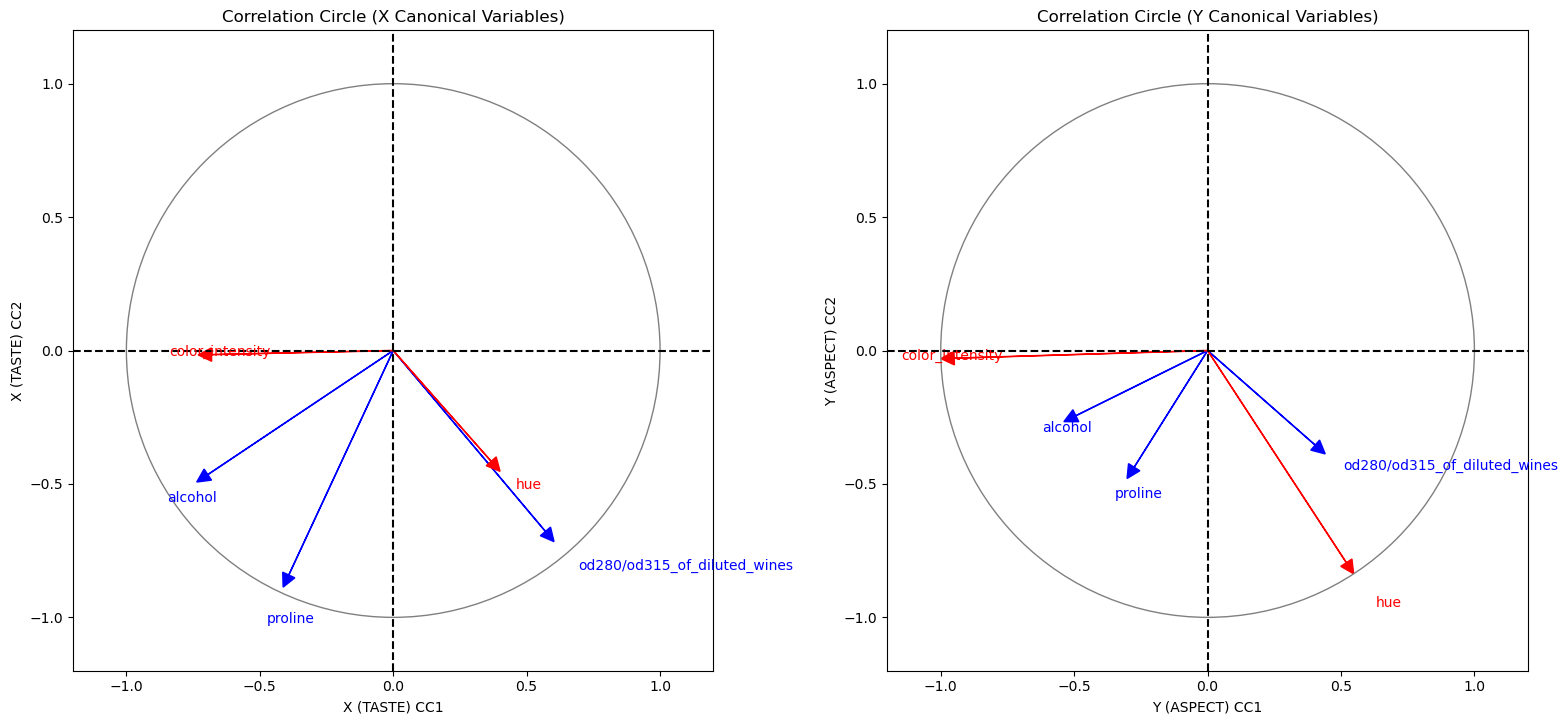

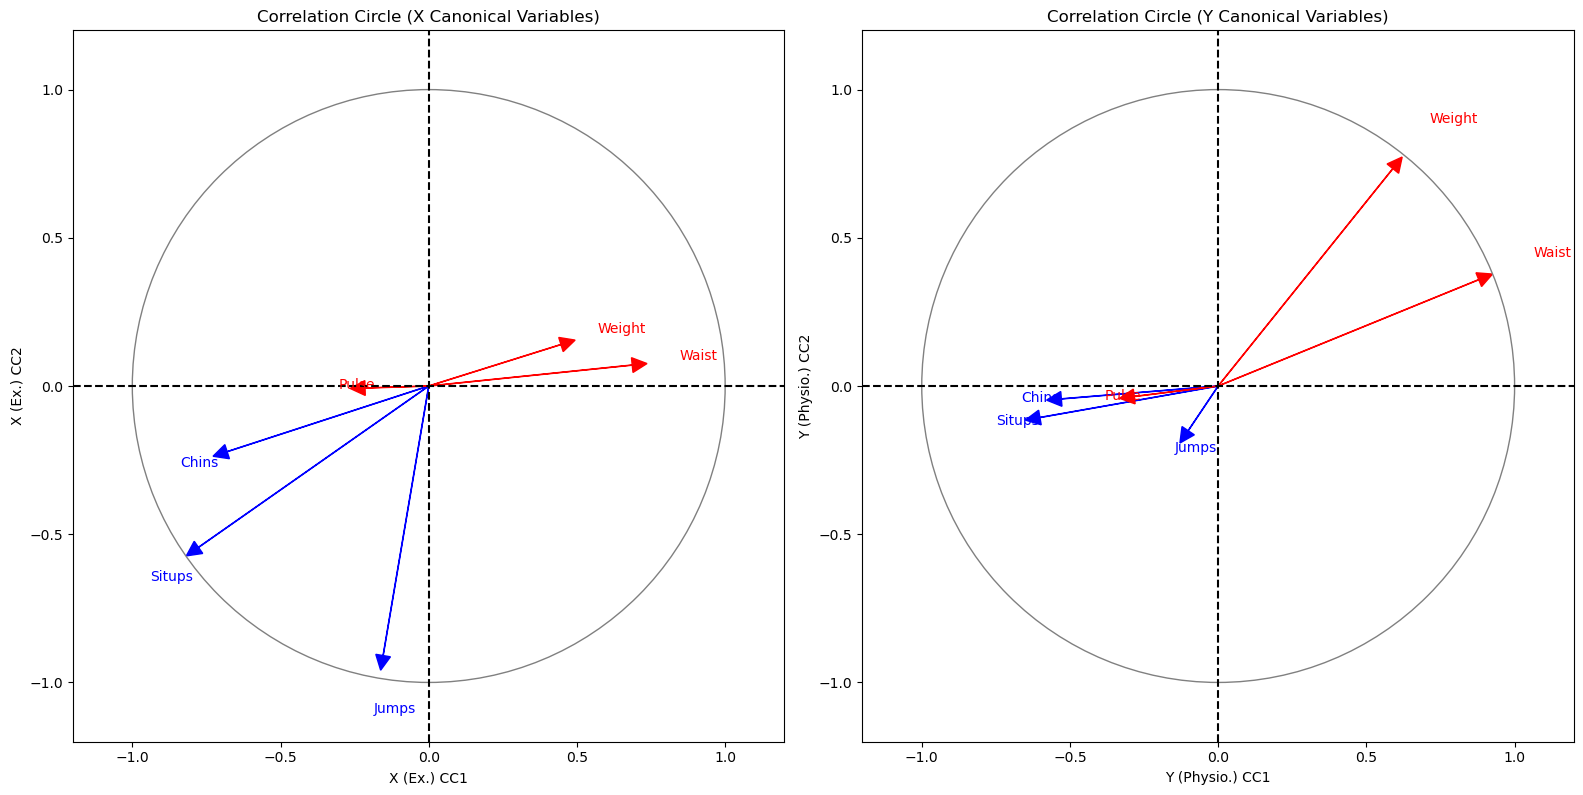

In [186]:
plot_correlation_circles( X_w, Y_w, X_c_w,Y_c_w,X_names= np.array(data_wine.feature_names)[ind_X], Y_names = np.array(data_wine.feature_names)[ind_Y], X_can = 'TASTE', Y_can= 'ASPECT')
plot_correlation_circles( X_ph, Y_ph, X_c_ph,Y_c_ph,X_names= np.array(X_ex.columns), Y_names = np.array(X_physio.columns), X_can = 'Ex.', Y_can= 'Physio.')


# Exercice 2 : Factorial correspondence analysis

In [189]:
# French assembly representatives data : 
data_dep = pd.read_csv('./deputes2.csv', on_bad_lines='skip',delimiter=';')
C_deputes = pd.crosstab(data_dep.GP, data_dep.CSP).T
print(C_deputes)

GP                                                 DEM  DR  ECOS  EPR  GDR  \
CSP                                                                          
Agriculteurs exploitants                             2   1     1    2    0   
Artisans, commerçants et chefs d'entreprise          3   4     1   14    0   
Autres personnes sans activité professionnelle       0   1     0    0    0   
Cadres et professions intellectuelles supérieures   26  36    29   65    9   
Employés                                             1   1     0    2    3   
Ouvriers                                             0   0     0    0    0   
Professions Intermédiaires                           2   0     3    7    5   
Retraités                                            1   3     2    6    0   
Sans profession déclarée                             1   1     2    1    0   

GP                                                 HOR  LFI-NFP  LIOT  NI  RN  \
CSP                                                         

In [191]:
# Column names
columns = ['Paris', 'Big city', 'Small', 'Other']
# Row names
index = ['Long', 'Short']

# Data students
C_student_ex_city = np.array([
    [5, 3, 7, 8],
    [5,1,4,4]

])

# Create the DataFrame
C_student_ex_city = pd.DataFrame(C_student_ex_city, columns=columns, index=index)

# Column names
columns = ['None', 'BDE', 'BDS', 'JE', 'Dance', 'Data', 'Bar']
# Row names
index = ['Math', 'Physics', 'Art', 'HistGeo', 'Sport', 'CompSc']

# Data students
C_student_favcour_assoc = np.array([
    [9, 2, 2, 2, 1, 3, 0],
    [4, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
    [0, 1, 3, 0, 1, 0, 0],
    [3, 0, 0, 0, 0, 0, 1],
])

# Create the DataFrame
C_student_favcour_assoc = pd.DataFrame(C_student_favcour_assoc, columns=columns, index=index)

print(C_student_ex_city)
print(C_student_favcour_assoc)

       Paris  Big city  Small  Other
Long       5         3      7      8
Short      5         1      4      4
         None  BDE  BDS  JE  Dance  Data  Bar
Math        9    2    2   2      1     3    0
Physics     4    0    0   0      0     0    0
Art         0    1    0   0      1     0    0
HistGeo     0    0    0   0      1     0    0
Sport       0    1    3   0      1     0    0
CompSc      3    0    0   0      0     0    1


## Question 2 : 

In [194]:
def compute_conditional(C):
    tot = sum(sum(np.array(C)))
    tot_col = np.sum(np.array(C),axis=0)
    tot_row = np.sum(np.array(C),axis=1)
    
    Pf = np.array(C)/tot
    Pf_tot_col = np.sum(Pf,axis=0)
    Pf_tot_row = np.sum(Pf,axis=1)
    
    Pf_row = np.zeros(Pf.shape)
    Pf_col = np.zeros(Pf.shape)
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            Pf_row[i,j] =  Pf[i,j]/Pf_tot_row[i]
            Pf_col[i,j] =  Pf[i,j]/Pf_tot_col[j]
            
    return Pf_row,Pf_col
    
cond_row, cond_col = compute_conditional(C_deputes)
print('Députés : ')
print(cond_row)
print(cond_col)    
cond_row, cond_col = compute_conditional(C_student_ex_city)
print('Student pref. exam/city : ')
print(cond_row)
print(cond_col)
cond_row, cond_col = compute_conditional(C_student_favcour_assoc)
print('Student fav. course/assoc. : ')
print(cond_row)
print(cond_col)

Députés : 
[[0.18181818 0.09090909 0.09090909 0.18181818 0.         0.
  0.         0.         0.         0.27272727 0.18181818 0.        ]
 [0.07142857 0.0952381  0.02380952 0.33333333 0.         0.11904762
  0.02380952 0.04761905 0.         0.16666667 0.02380952 0.0952381 ]
 [0.         0.5        0.         0.         0.         0.
  0.         0.         0.         0.5        0.         0.        ]
 [0.06649616 0.09207161 0.0741688  0.16624041 0.0230179  0.05882353
  0.10741688 0.04859335 0.01534527 0.18925831 0.13299233 0.02557545]
 [0.03030303 0.03030303 0.         0.06060606 0.09090909 0.03030303
  0.3030303  0.         0.         0.42424242 0.03030303 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.5        0.         0.         0.5        0.         0.        ]
 [0.03773585 0.         0.05660377 0.13207547 0.09433962 0.05660377
  0.20754717 0.         0.         0.26415094 0.1509434  0.        ]
 [0.04545455 0.13636364 0.09090909 0.27272727 0.      

## Question 3-4 : 

In [197]:
def compute_E(C):
    E = np.zeros(C.shape)
    tot_col = np.sum(np.array(C),axis=0)
    tot_row = np.sum(np.array(C),axis=1)
    tot = sum(sum(np.array(C)))
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
        
            E[i,j] = tot_row[i]*tot_col[j]/tot
    return E


def chi_square_dist(C,E):
    residuals = np.zeros(C.shape)
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):   
            residuals[i,j] = (np.array(C)[i,j] - E[i,j])/np.sqrt(E[i,j])
    return residuals, np.sum(np.sum(np.power(residuals,2),axis=1),axis=0)

def plot_circle_table(data, row_labels, col_labels,cmap=plt.cm.RdBu):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_axis_off()

    # Normalize data for color mapping
    norm = plt.Normalize(vmin=np.min(data), vmax=np.max(data))
    #cmap = plt.cm.RdBu  # Red-Blue colormap

    # Calculate circle sizes
    max_radius = 0.4
    sizes = data / np.max(data) * max_radius

    for i, row in enumerate(data):
        for j, val in enumerate(row):
            circle = plt.Circle((j, -i), sizes[i, j], 
                                color=cmap(norm(val)), 
                                fill=True)
            ax.add_artist(circle)
            #ax.text(j, -i, f'{val:.2f}', ha='center', va='center')

    # Set table properties
    ax.set_xlim(-0.5, len(col_labels) - 0.5)
    ax.set_ylim(-len(row_labels) + 0.5, 0.5)
    ax.set_aspect('equal')

    # Add row and column labels
    for i, label in enumerate(row_labels):
        ax.text(-0.7, -i, label, ha='right', va='center')
    for j, label in enumerate(col_labels):
        ax.text(j, 0.7, label, ha='center', va='bottom', rotation=45)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm,ax=ax,shrink=0.5)

    plt.tight_layout()
    plt.show()

In [199]:
print('Députés : ')
res,chi_dist = chi_square_dist(C_deputes,compute_E(C_deputes))
print('Chi-squared distance : ', chi_dist) 
plot_circle_table(res,C_deputes.T.keys(),C_deputes.keys())

Députés : 
Chi-squared distance :  132.4266625444906


In [201]:
print('Student pref. exam/city : ')
res,chi_dist = chi_square_dist(C_student_ex_city,compute_E(C_student_ex_city))
print('Chi-squared distance : ', chi_dist) 
plot_circle_table(res,C_student_ex_city.T.keys(),C_student_ex_city.keys())

Student pref. exam/city : 
Chi-squared distance :  1.0228449087144738


In [203]:
print('Student fav. course/assoc. : ')
res,chi_dist = chi_square_dist(C_student_favcour_assoc,compute_E(C_student_favcour_assoc))
print('Chi-squared distance : ', chi_dist) 
plot_circle_table(res,C_student_favcour_assoc.T.keys(),C_student_favcour_assoc.keys())

Student fav. course/assoc. : 
Chi-squared distance :  43.334375


In [205]:
def perform_fca(contingency_table, row_labels, col_labels, normalize=True):
    """
    Perform Factorial Correspondence Analysis from a contingency table.
    
    Parameters:
    contingency_table (numpy.array): 2D array representing the contingency table
    row_labels (list): Labels for the rows
    col_labels (list): Labels for the columns
    normalize (bool): Whether to normalize FCA coordinates (default: True)
    
    Returns:
    F (numpy.array): Principal coordinates for rows
    G (numpy.array): Principal coordinates for columns
    """
    
    # Convert to numpy array if not already
    C = np.array(contingency_table)
    
    # Calculate row and column sums
    row_sums = C.sum(axis=1)
    col_sums = C.sum(axis=0)
    total = C.sum()
    rank = min(C.shape[0],C.shape[1])
    # Create diagonal matrices
    D_r = np.diag(row_sums)
    D_c = np.diag(col_sums)
    
    # Calculate the matrix of standardized residuals
    expected = np.outer(row_sums, col_sums) / total
    R = (C - expected) / np.sqrt(expected)
    
    # Singular Value Decomposition
    U, s, Vt = np.linalg.svd(R, full_matrices=True)

    # Calculate principal coordinates
    if normalize:
        F = np.dot(np.linalg.inv(np.sqrt(D_r)), U)[:,:rank]*s
        G = np.dot(np.linalg.inv(np.sqrt(D_c)), Vt.T)[:,:rank]*s

    else:
        F = U[:,:rank]*s
        G = Vt.T[:,:rank]*s

    return s, U, Vt, F, G

def plot_fca(F,G, row_labels, col_labels, ind0 = 0, ind1 = 1):
    # Create biplot
    plt.figure(figsize=(10, 8))
    plt.scatter(F[:, ind0], F[:, ind1], color='red', label='Rows')
    plt.scatter(G[:, ind0], G[:, ind1], color='blue', label='Columns')
    
    ec1 = 0.01*(max(np.amax(F[:, ind0]),np.amax(G[:, ind0])) - min(np.amin(F[:, ind0]),np.amin(G[:, ind0])))
    ec2 = 0.01*(max(np.amax(F[:, ind1]),np.amax(G[:, ind1])) - min(np.amin(F[:, ind1]),np.amin(G[:, ind1])))
    for i, txt in enumerate(row_labels):
        plt.annotate(txt, (F[i, ind0]+ec1, F[i, ind1]+ec2), color='red')
    for i, txt in enumerate(col_labels):
        plt.annotate(txt, (G[i, ind0]+ec1, G[i, ind1]+ec2), color='blue')
    per1 = int(100*s[0]**2/np.power(s,2).sum())
    per2 = int(100*s[1]**2/np.power(s,2).sum())
    plt.axhline(y=0, color='k', linestyle='--')
    plt.axvline(x=0, color='k', linestyle='--')
    plt.xlabel('Dimension 1 ('+str(per1)+' %)')
    plt.ylabel('Dimension 2 ('+str(per2)+' %)')
    plt.title('Factorial Correspondence Analysis Biplot')
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [207]:
s, U, Vt, F, G = perform_fca(C_deputes,C_deputes.T.keys(),C_deputes.keys(),normalize=True)

plot_fca(F,G, C_deputes.T.keys(), C_deputes.keys())

# Eigenvalues are singular values to the power 2 and chi-squared distance is the sum of eigenvalues
cumulative_chi_squared_ratio = np.cumsum(np.power(s,2)) / sum(np.power(s,2))
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_chi_squared_ratio) + 1), 
         cumulative_chi_squared_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.show()

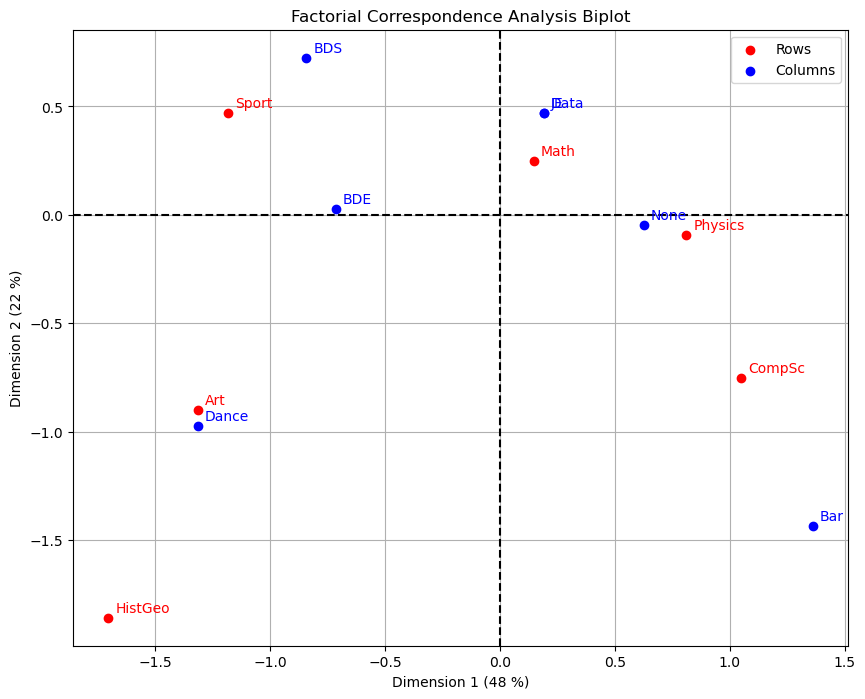

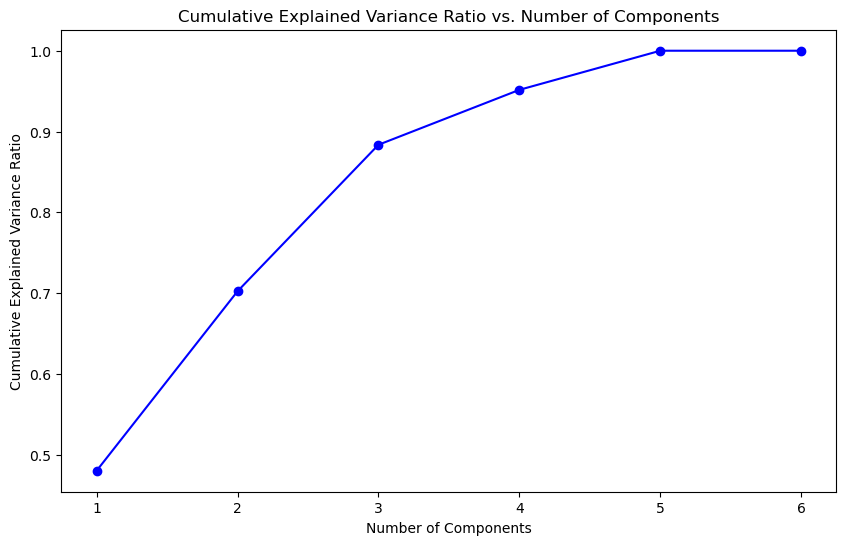

In [209]:
s, U, Vt, F, G = perform_fca(C_student_favcour_assoc,C_student_favcour_assoc.T.keys(),C_student_favcour_assoc.keys(),normalize=True)

plot_fca(F,G, C_student_favcour_assoc.T.keys(), C_student_favcour_assoc.keys())

# Eigenvalues are singular values to the power 2 and chi-squared distance is the sum of eigenvalues
cumulative_chi_squared_ratio = np.cumsum(np.power(s,2)) / sum(np.power(s,2))
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_chi_squared_ratio) + 1), 
         cumulative_chi_squared_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.show()

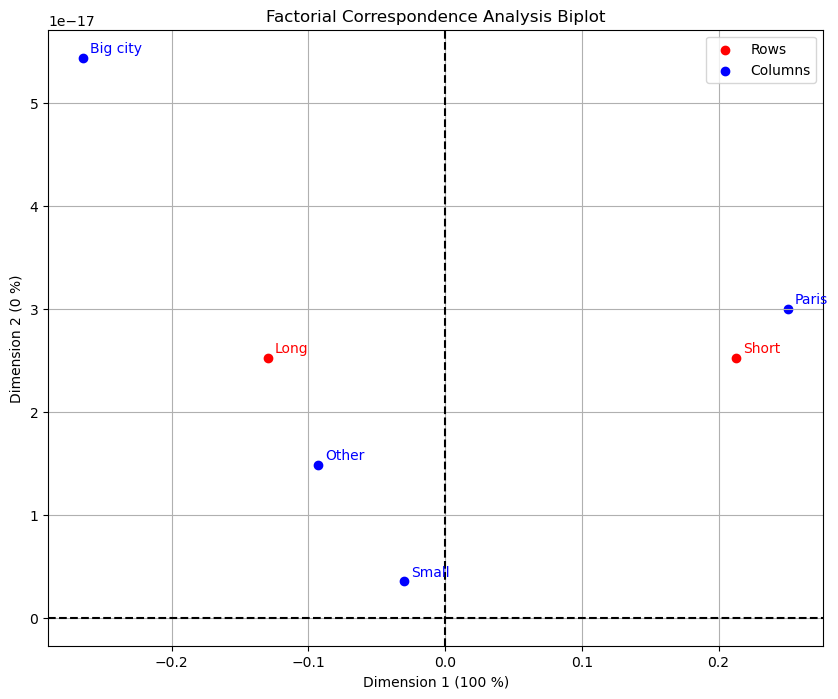

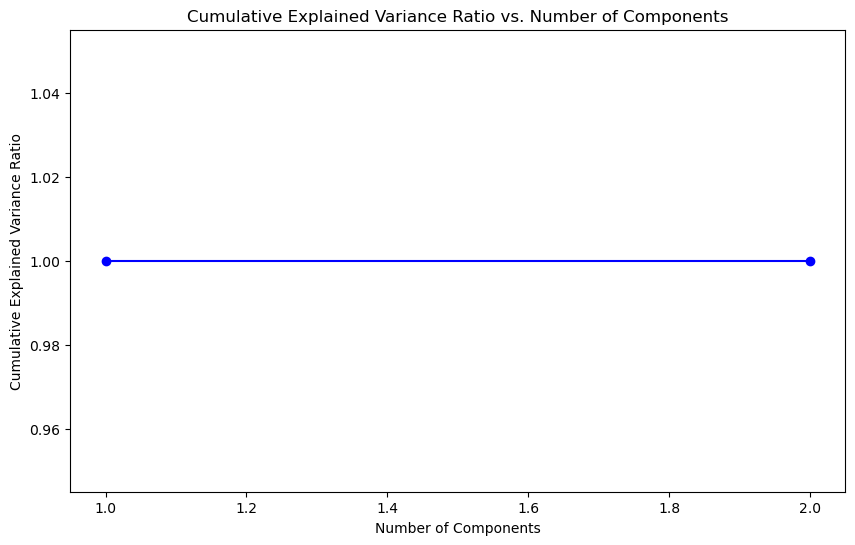

In [211]:
s, U, Vt, F, G = perform_fca(C_student_ex_city,C_student_ex_city.T.keys(),C_student_ex_city.keys(),normalize=True)

plot_fca(F,G, C_student_ex_city.T.keys(), C_student_ex_city.keys())

# Eigenvalues are singular values to the power 2 and chi-squared distance is the sum of eigenvalues
cumulative_chi_squared_ratio = np.cumsum(np.power(s,2)) / sum(np.power(s,2))
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_chi_squared_ratio) + 1), 
         cumulative_chi_squared_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.show()

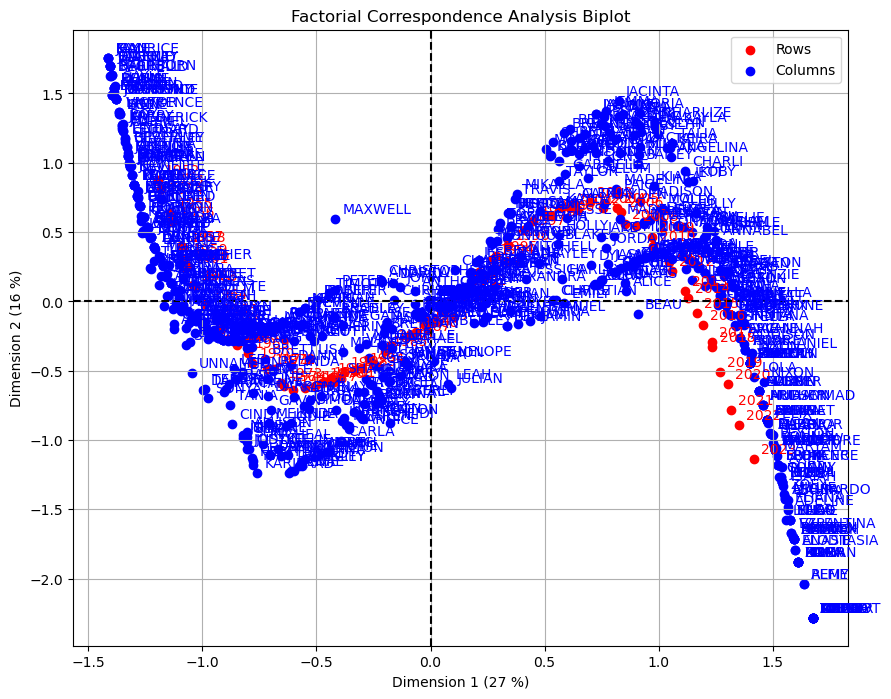

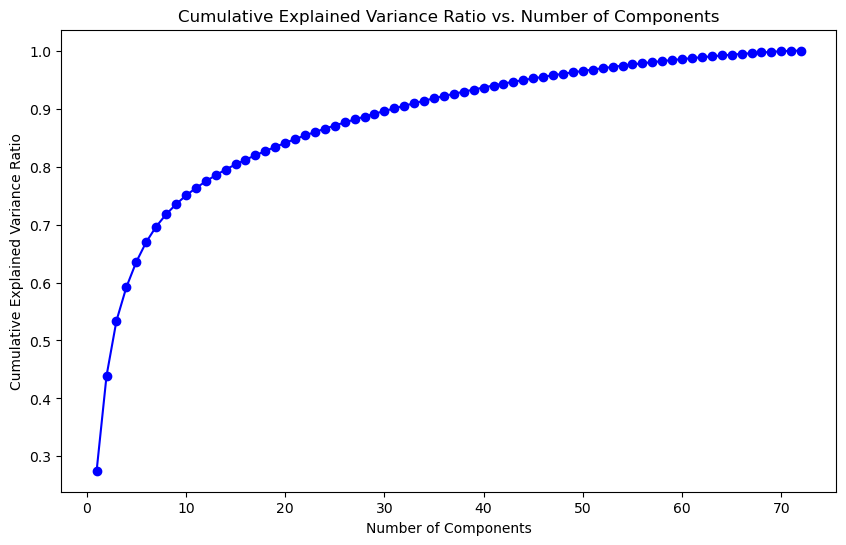

In [213]:
data_names = pd.read_csv('./popular_names.csv', on_bad_lines='skip',delimiter=',')

C_names = pd.crosstab(data_names.Year, data_names.Name)

s, U, Vt, F, G = perform_fca(C_names,C_names.T.keys(),C_names.keys(),normalize=True)

plot_fca(F,G, C_names.T.keys(), C_names.keys(),ind0 = 0,ind1 = 1)

plot_fca(F,G, C_names.T.keys(), C_names.keys(),ind0 = 0,ind1 = 2)

# Eigenvalues are singular values to the power 2 and chi-squared distance is the sum of eigenvalues
cumulative_chi_squared_ratio = np.cumsum(np.power(s,2)) / sum(np.power(s,2))
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_chi_squared_ratio) + 1), 
         cumulative_chi_squared_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.show()